In [17]:
import os
from pathlib import PosixPath
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib as mpl
from collections import OrderedDict

tqdm.pandas(ncols=50)

## Data preparation

In [20]:
df = None

for path in [
    'data/centralized3_equilateral_1000traj_9/*.csv',
    'data/trained3_equilateral_1000traj/*.csv',
    'data/trained3_quadpedal_1000traj/*.csv',
]:
    assert len(glob.glob(path)) > 0, f'No files found for {path}'

    for file in glob.glob(path):
        df_ = pd.read_csv(file, index_col=0)

        if df is None:
            df = df_
        else:
            # Merge rows
            df = pd.concat([df, df_], ignore_index=True)


def extend_columns(x):
    run_args = eval(x['run_args'])

    res = dict(
        command_x=run_args['command']['x'],
        command_y=run_args['command']['y'],
        command_t=run_args['command']['t'],
        command_h=run_args['command']['h'],
        terrain=run_args['env']['terrain'],
        force=run_args['env']['force'],
        policy=run_args['env']['policy'],
    )

    total_power = 0
    for i, power in enumerate(list(map(float, x['power'][1:-1].split()))):
        res[f'power_{i}'] = power
        total_power += power

    res['power'] = total_power

    joint_forces = []
    for i, joint_force in enumerate(list(map(float, x['joint_forces'][1:-1].split()))):
        res[f'joint_forces_{i}'] = joint_force
        joint_forces.append(joint_force)

    res['joint_forces'] = np.mean(joint_forces)

    res['perturbation_force_start'], res['perturbation_force_end'] \
        = map(int, x['perturbation_force_bound'][1:-1].split(','))

    res['perturbation_force_window'] = res['perturbation_force_end'] - res['perturbation_force_start']

    total_height_diff = 0
    for i, height_diff in enumerate(list(map(float, x['height_diff'][1:-1].split()))):
        res[f'height_diff_{i}'] = height_diff
        total_height_diff += height_diff

    res['height_diff'] = total_height_diff

    return res


df = pd.concat([df.progress_apply(lambda x: pd.Series(extend_columns(x)), axis=1), df], axis=1)
df = df.loc[:, ~df.columns.duplicated()]

# Merge another dataset
df = pd.concat([df, pd.read_csv('data/mix/special_central3.csv', index_col=0)], axis=0)

df.columns.duplicated().any()

100%|█████| 72000/72000 [00:19<00:00, 3602.59it/s]


False

In [21]:
df.groupby(['policy', 'terrain']).size()

policy                                         terrain               
Central2                                       cassiepede                24000
Number4                                        cassiepede_rectangle      24000
PositionB                                      cassiepede_t_shape_b      24000
ShapeA                                         cassiepede_shape_a        24000
WeightC                                        cassiepede_weight_c       24000
centralized3                                   cassiepede_equilateral    24000
trained_3_torque_joint_force_randomize_weight  cassiepede_centralized    24000
                                               cassiepede_equilateral    24000
dtype: int64

<Axes: xlabel='force', ylabel='failure_rate'>

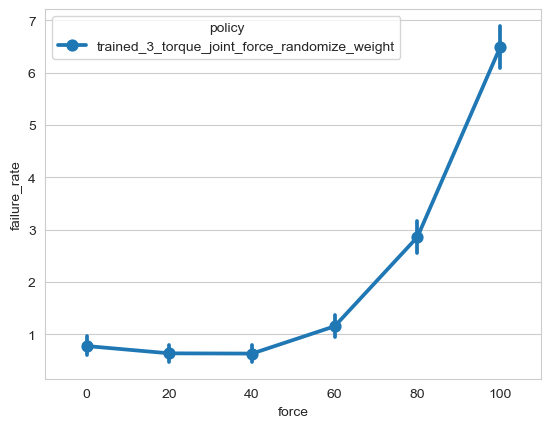

In [22]:
df['failure_rate'] = (1000 - df['episode_length']) / 10
# 
sns.pointplot(data=df[
    df.policy.isin(['trained_2_torque_joint_force_randomize_weight', 'trained_3_torque_joint_force_randomize_weight'])],
             x='force', y='failure_rate', hue='policy', errorbar=('ci', 95))

## Failure rate across different policies

/var/folders/hn/tndm9dyn3dd0xbtnwgv3m9cr0000gn/T/ipykernel_98301/1859617644.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Quadrapedal', 'Hexapedal'], rotation=0, ha='right')


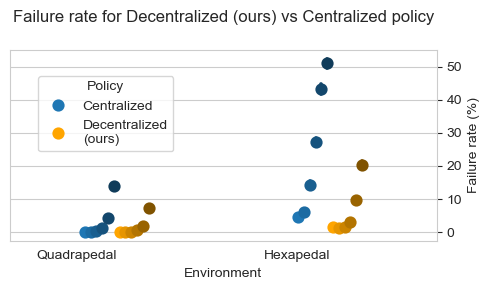

In [23]:
plt.figure(figsize=(5, 3))

policies = [
    ('Central2', 'Centralized'),
    ('centralized3', 'Centralized'),
    ('centralized', 'Centralized'),
    ('trained_3_torque_joint_force_randomize_weight', 'Decentralized\n(ours)'),
]

policies = OrderedDict(policies)

df_ = df.copy()

df_ = df_[df_.policy.isin(policies.keys())]

# Name all centralized policies as centralized
df_.loc[df_.policy.isin(['Central2', 'centralized3']), 'policy'] = 'centralized'

# Differentiate centralize policies by their terrain name
df_.loc[df_.terrain.isin(['cassiepede', 'cassiepede_centralized']), 'terrain'] = 'cassiepede_quadraped'
df_.loc[df_.terrain.isin(['cassiepede_equilateral']), 'terrain'] = 'cassiepede_hexapedal'

# df_['failure_rate'] = (1000 - df_['episode_length']) / 10
df_['failure_rate'] = (df_['episode_length'] < 1000).astype(int) * 100.0

cmap = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)

df_['policy_force'] = df_['policy'] + '_' + df_['force'].astype(str)

base_colors = {'centralized': 'tab:blue',
               'trained_3_torque_joint_force_randomize_weight': 'orange'}

# Create a list of colors with varying brightness
palette = []
for cat in df_.policy.unique():
    for val in df_.force.unique():
        # Vary brightness by changing the intensity
        color = sns.color_palette([base_colors[cat]], n_colors=1)[0]
        palette.append(tuple(np.array(color) * (1 - val / 200)))

# Create a dictionary mapping the combined values to the colors
combined_hue_palette = {f'{cat}_{val}': palette[i] for i, (cat, val) in
                        enumerate([(c, v) for c in df_.policy.unique() for v in df_.force.unique()])}

hue_order = [f'{cat}_{val}' for cat in sorted(df_.policy.unique()) for val in sorted(df_.force.unique())]

ax = sns.pointplot(data=df_, x='terrain', y='failure_rate', hue='policy_force', errorbar=('ci', 95), linestyles='none',
                   dodge=True,
                   palette=combined_hue_palette,
                   hue_order=hue_order,
                   order=['cassiepede_quadraped', 'cassiepede_hexapedal'])

ax.set_ylabel('Failure rate (%)')
ax.set_xlabel('Environment')

handles, labels = ax.get_legend_handles_labels()

order_idx = [0, 6]

handles = [handles[i] for i in order_idx]
labels = [labels[i] for i in order_idx]

ax.legend(handles=handles,
          labels=[policies[k] for k in base_colors.keys()],
          title='Policy',
          loc='upper left',
          bbox_to_anchor=(0.05, 0.9))

ax.yaxis.set_major_formatter(lambda x, pos: f'{x:g}')

ax.set_xticklabels(['Quadrapedal', 'Hexapedal'], rotation=0, ha='right')

ax.set_title('Failure rate for Decentralized (ours) vs Centralized policy', pad=20)

ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')

plt.tight_layout()
plt.savefig('plot.png', dpi=300, bbox_inches='tight')
plt.savefig('plot.pdf', dpi=300, bbox_inches='tight')

df ## XY drift across different policies

### Bar plot

/var/folders/hn/tndm9dyn3dd0xbtnwgv3m9cr0000gn/T/ipykernel_65796/1428793376.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(['Quadrapedal', 'Hexapedal'], rotation=0, ha='center')
/var/folders/hn/tndm9dyn3dd0xbtnwgv3m9cr0000gn/T/ipykernel_65796/1428793376.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(['Quadrapedal', 'Hexapedal'], rotation=0, ha='center')


<Figure size 500x300 with 0 Axes>

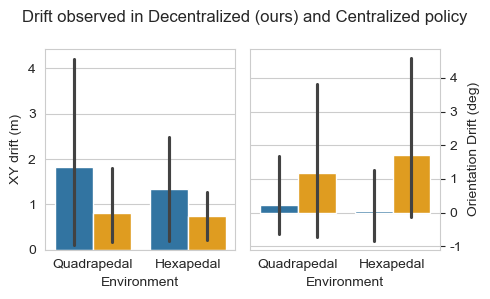

In [33]:
plt.figure(figsize=(5, 3))

policies = [
    ('Central2', 'Centralized'),
    ('centralized3', 'Centralized'),
    ('centralized', 'Centralized'),
    ('trained_3_torque_joint_force_randomize_weight', 'Decentralized\n(ours)'),
]

policies = OrderedDict(policies)

df_ = df.copy()

df_ = df_[df_.policy.isin(policies.keys())]

# Name all centralized policies as centralized
df_.loc[df_.policy.isin(['Central2', 'centralized3']), 'policy'] = 'centralized'

# Differentiate centralize policies by their terrain name
df_.loc[df_.terrain.isin(['cassiepede', 'cassiepede_centralized']), 'terrain'] = 'cassiepede_quadraped'
df_.loc[df_.terrain.isin(['cassiepede_equilateral']), 'terrain'] = 'cassiepede_hexapedal'

# df_['failure_rate'] = (1000 - df_['episode_length']) / 10
df_['failure_rate'] = (df_['episode_length'] < 1000).astype(int) * 100.0

# Group and aggregate
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(5, 3))

df_ = df_.groupby(
    ['policy', 'terrain', 'command_x', 'command_y', 'command_t']).agg(
    {'odometry_x': 'mean', 'odometry_y': 'mean', 'orientation_error': 'mean', 'episode_length': 'mean'})

# Reset index to create table from grouped table
df_ = df_.reset_index()

df_.loc[df_['command_x'] == 1, 'odometry_x'] = 20 - df_.loc[df_['command_x'] == 1, 'odometry_x']
df_.loc[df_['command_y'] == 0.25, 'odometry_y'] = 5 - df_.loc[df_['command_y'] == 0.25, 'odometry_y']
df_['orientation_error'] = -df_['orientation_error']

df_['drift_xy'] = (np.sqrt(df_['odometry_x'] ** 2 + df_['odometry_y'] ** 2))  #+ df_['orientation_error'].abs()

custom_palette = {
    'centralized': 'tab:blue',
    'trained_3_torque_joint_force_randomize_weight': 'orange',
}

sns.barplot(data=df_, x='terrain', y='drift_xy', hue='policy', errorbar=('ci', 95), palette=custom_palette, ax=ax1)

sns.barplot(data=df_, x='terrain', y='orientation_error', hue='policy', errorbar=('ci', 95),
            palette=custom_palette,
            ax=ax2,
            order=['cassiepede_quadraped', 'cassiepede_hexapedal'])

ax1.set_ylabel('XY drift (m)')
ax2.set_ylabel('Orientation Drift (deg)')

ax1.set_xlabel('Environment')
ax2.set_xlabel('Environment')

ax1.yaxis.set_major_formatter(lambda x, pos: f'{x:g}')
ax2.yaxis.set_major_formatter(lambda x, pos: f'{x:g}')

ax1.set_xticklabels(['Quadrapedal', 'Hexapedal'], rotation=0, ha='center')
ax2.set_xticklabels(['Quadrapedal', 'Hexapedal'], rotation=0, ha='center')

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')

ax1.legend_.remove()
ax2.legend_.remove()

fig.suptitle('Drift observed in Decentralized (ours) and Centralized policy')

plt.tight_layout()
plt.savefig('plot.png', dpi=300, bbox_inches='tight')
plt.savefig('plot.pdf', dpi=300, bbox_inches='tight')

### Box plot

/var/folders/hn/tndm9dyn3dd0xbtnwgv3m9cr0000gn/T/ipykernel_65796/3229885126.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(['Quadrapedal', 'Hexapedal'], rotation=0, ha='center')
/var/folders/hn/tndm9dyn3dd0xbtnwgv3m9cr0000gn/T/ipykernel_65796/3229885126.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(['Quadrapedal', 'Hexapedal'], rotation=0, ha='center')


<Figure size 500x300 with 0 Axes>

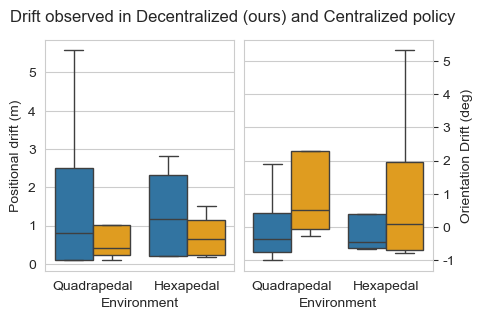

In [34]:
plt.figure(figsize=(5, 3))

policies = [
    ('Central2', 'Centralized'),
    ('centralized3', 'Centralized'),
    ('centralized', 'Centralized'),
    ('trained_3_torque_joint_force_randomize_weight', 'Decentralized\n(ours)'),
]

policies = OrderedDict(policies)

df_ = df.copy()

df_ = df_[df_.policy.isin(policies.keys())]

# Name all centralized policies as centralized
df_.loc[df_.policy.isin(['Central2', 'centralized3']), 'policy'] = 'centralized'

# Differentiate centralize policies by their terrain name
df_.loc[df_.terrain.isin(['cassiepede', 'cassiepede_centralized']), 'terrain'] = 'cassiepede_quadraped'
df_.loc[df_.terrain.isin(['cassiepede_equilateral']), 'terrain'] = 'cassiepede_hexapedal'

# df_['failure_rate'] = (1000 - df_['episode_length']) / 10
df_['failure_rate'] = (df_['episode_length'] < 1000).astype(int) * 100.0

# Group and aggregate
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(5, 3))

df_ = df_.groupby(
    ['policy', 'terrain', 'command_x', 'command_y', 'command_t']).agg(
    {'odometry_x': 'mean', 'odometry_y': 'mean', 'orientation_error': 'mean', 'episode_length': 'mean'})

# Reset index to create table from grouped table
df_ = df_.reset_index()

df_.loc[df_['command_x'] == 1, 'odometry_x'] = 20 - df_.loc[df_['command_x'] == 1, 'odometry_x']
df_.loc[df_['command_y'] == 0.25, 'odometry_y'] = 5 - df_.loc[df_['command_y'] == 0.25, 'odometry_y']
df_['orientation_error'] = -df_['orientation_error']

df_['drift_xy'] = (np.sqrt(df_['odometry_x'] ** 2 + df_['odometry_y'] ** 2))  #+ df_['orientation_error'].abs()

custom_palette = {
    'centralized': 'tab:blue',
    'trained_3_torque_joint_force_randomize_weight': 'orange',
}


sns.boxplot(data=df_,
            x='terrain', y='drift_xy', hue='policy', showfliers=False, ax=ax1, palette=custom_palette)

sns.boxplot(data=df_,
            x='terrain', y='orientation_error', hue='policy', showfliers=False, ax=ax2, palette=custom_palette)

ax1.set_ylabel('Positional drift (m)')
ax2.set_ylabel('Orientation Drift (deg)')

ax1.set_xlabel('Environment')
ax2.set_xlabel('Environment')

ax1.yaxis.set_major_formatter(lambda x, pos: f'{x:g}')
ax2.yaxis.set_major_formatter(lambda x, pos: f'{x:g}')

ax1.set_xticklabels(['Quadrapedal', 'Hexapedal'], rotation=0, ha='center')
ax2.set_xticklabels(['Quadrapedal', 'Hexapedal'], rotation=0, ha='center')

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')

ax1.legend_.remove()
ax2.legend_.remove()

fig.suptitle('Drift observed in Decentralized (ours) and Centralized policy')

plt.subplots_adjust(wspace=0.05, hspace=0.0)

plt.savefig('plot.png', dpi=300, bbox_inches='tight')